Vasmos a cargar el dataset de AirBnB descargado de [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets)

![](descargar.png)

In [1]:
airbnb<-read.csv('airbnb-listings.csv',sep = ';')
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)

Vamos a quedarnos con las columnas de mayor interés:

'City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude'

In [249]:
airbnb <- subset(airbnb,select = c('City','Room.Type','Neighbourhood','Accommodates',
                                   'Bathrooms','Bedrooms','Beds','Price','Square.Feet',
                                   'Guests.Included','Extra.People','Review.Scores.Rating',
                                   'Latitude','Longitude'))

Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [250]:
df_madrid <- airbnb[airbnb$City=="Madrid" &
                    airbnb$Room.Type=="Entire home/apt" & 
                    airbnb$Neighbourhood != "",]

df_madrid$Room.Type <- NULL
df_madrid$City <- NULL

Crea una nueva columna llamada Square.Meters a partir de Square.Feet. Recuerda que un pie cuadrado son 0.092903 metros cuadrados.

In [251]:
df_madrid$Square.Meters <- round(df_madrid$Square.Feet * 0.092903)

¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir, ¿cuantos tienen NA en Square.Meters?

In [252]:
total_rows = nrow(df_madrid)
rows_without_meters = nrow(df_madrid[is.na(df_madrid$Square.Meters),])
porcentaje = round(rows_without_meters/total_rows*100, 2)

In [253]:
porcentaje

[1] 93.8

De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [254]:
apart_with_zero_meters <- nrow(df_madrid[!is.na(df_madrid$Square.Meters) & 
                                    df_madrid$Square.Meters == 0,])
apart_with_meters <- nrow(df_madrid[!is.na(df_madrid$Square.Meters),])

porcentaje = round(apart_with_zero_meters / apart_with_meters*100,2)

In [255]:
porcentaje

[1] 36.89

Reemplazar todos los 0m^2 por NA 

In [256]:
df_madrid$Square.Meters[df_madrid$Square.Meters == 0] <- NA

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA. Pero **antes de crear el modelo** vamos a hacer:
* pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.
* crearemos una variable sintética nueva basada en la similitud entre barrios que usaremos en nuestro modelo.

Pinta el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más

Warning message:
“Removed 5382 rows containing non-finite values (stat_bin).”


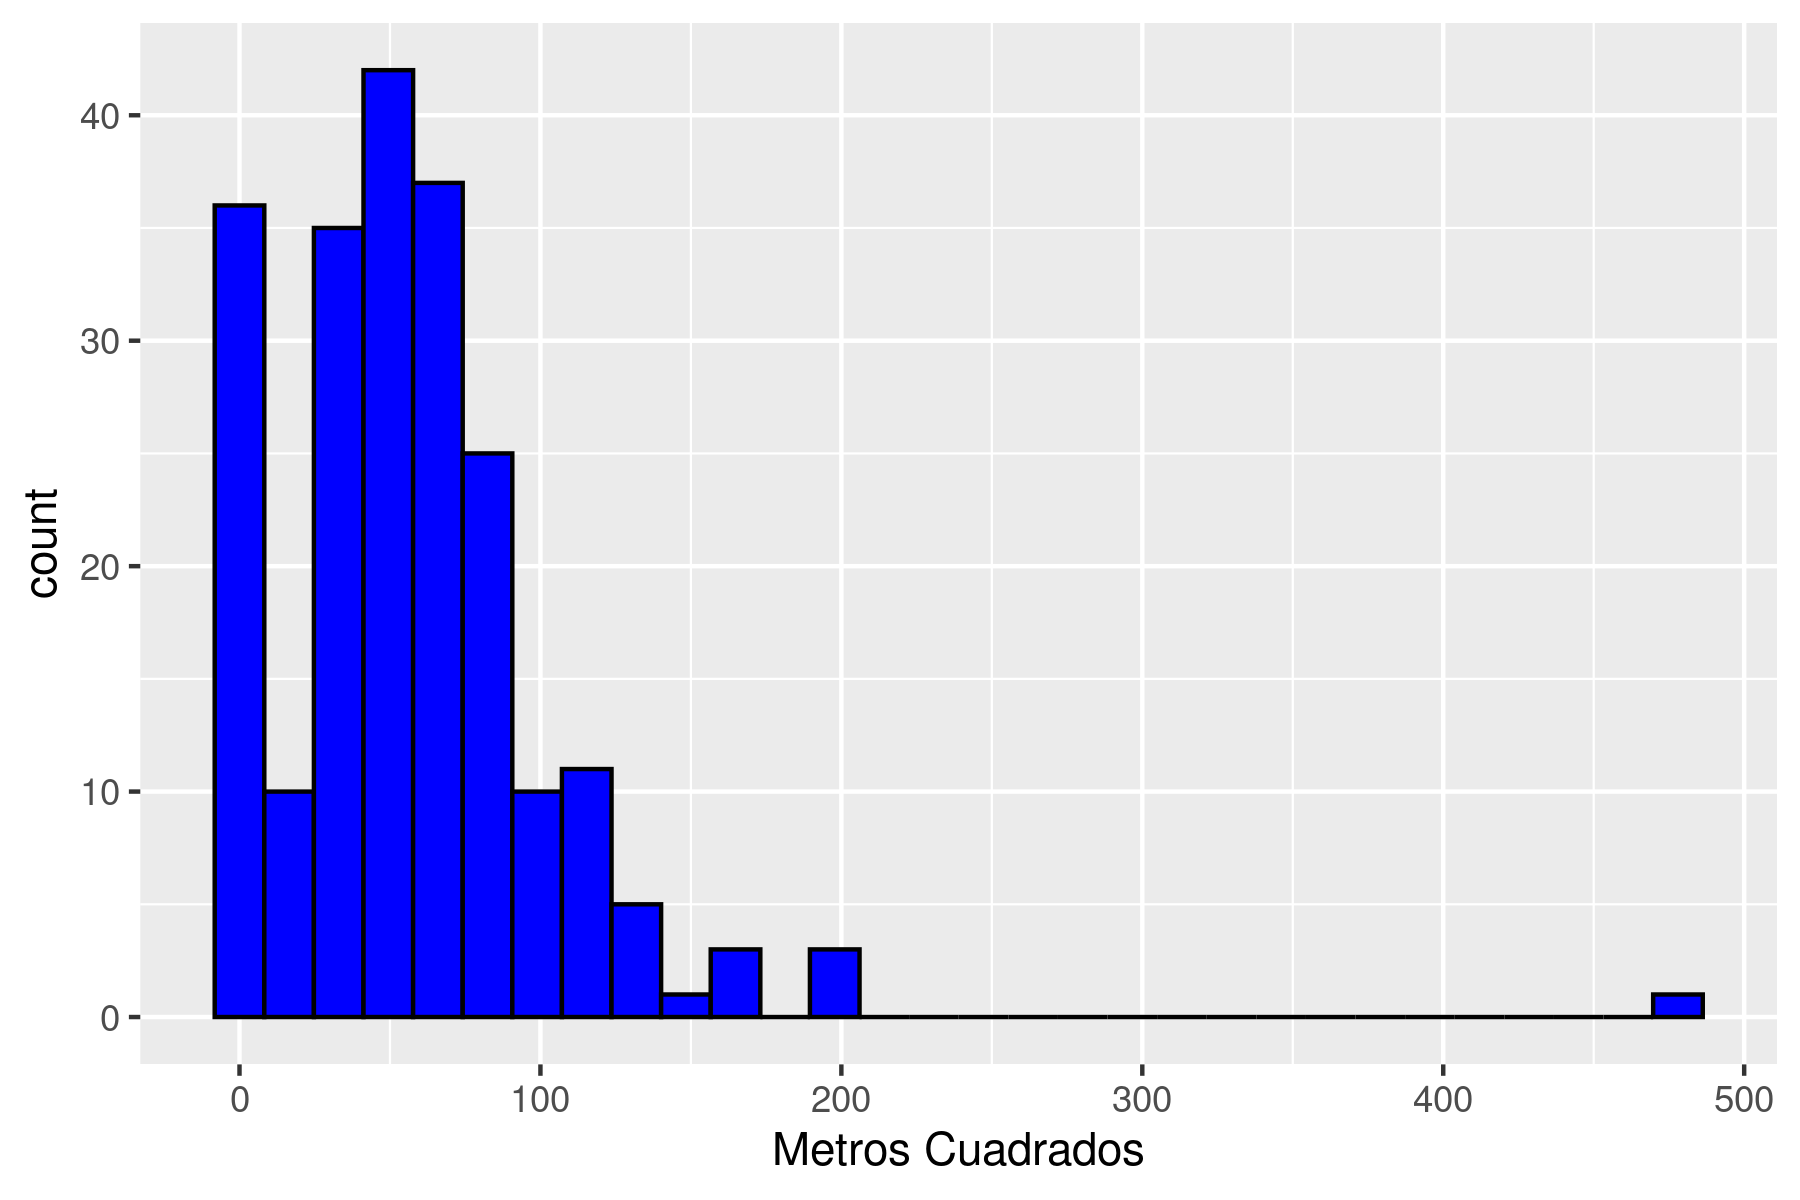

In [257]:
library(ggplot2)
ggplot(data=df_madrid, aes(x=Square.Meters))+
geom_histogram(bins=30, fill="blue", color="black")+
xlab("Metros Cuadrados")

Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [258]:
df_madrid$Square.Meters[df_madrid$Square.Meters < 20] <- NA

Existen varios Barrios que todas sus entradas de Square.Meters son NA, vamos a eliminar del dataset todos los pisos que pertenecen a estos barrios.

In [259]:
library(dplyr)

df_madrid %>% group_by(Neighbourhood) %>% summarize(num_na=length(na.omit(Square.Meters))) -> d

d <- d$Neighbourhood[d$num_na !=0]

df_madrid <- df_madrid[df_madrid$Neighbourhood %in% d,] 

El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

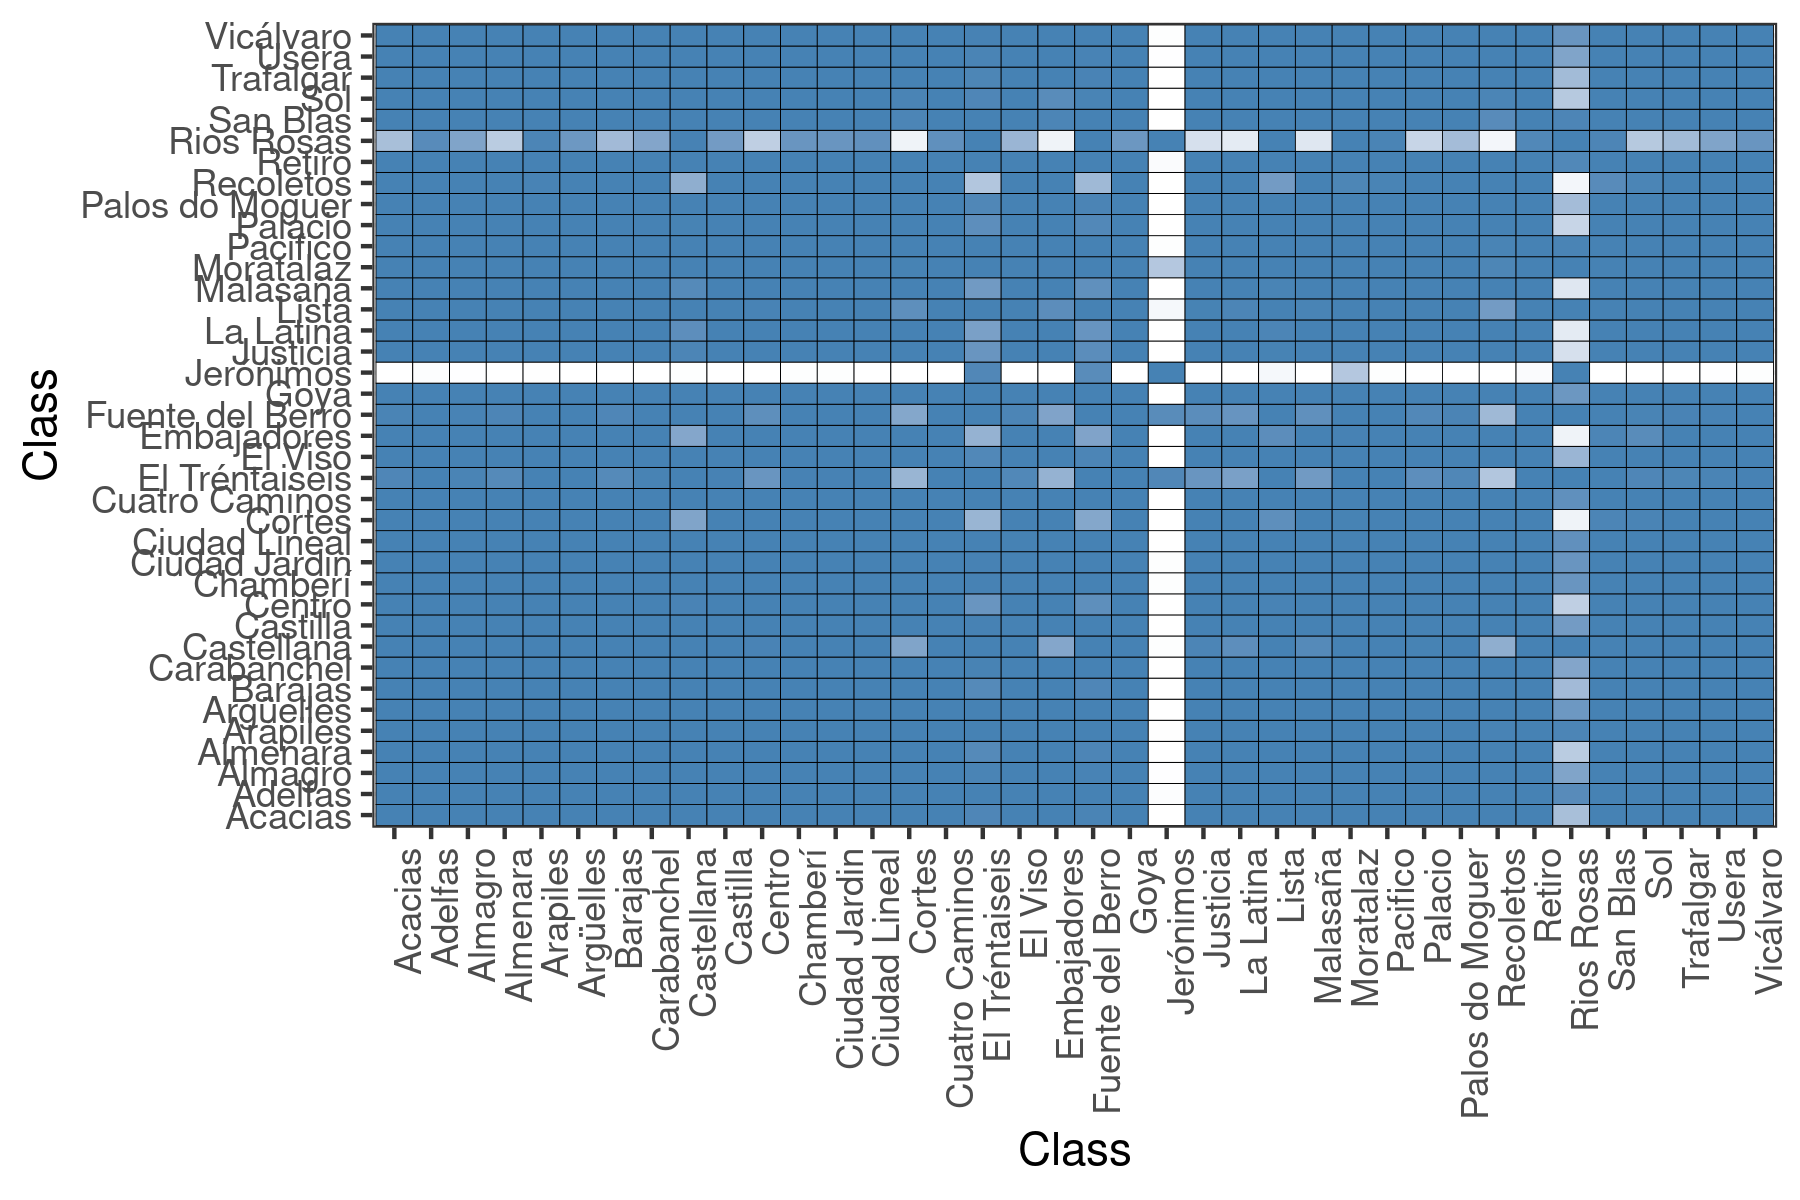

In [260]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid ))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


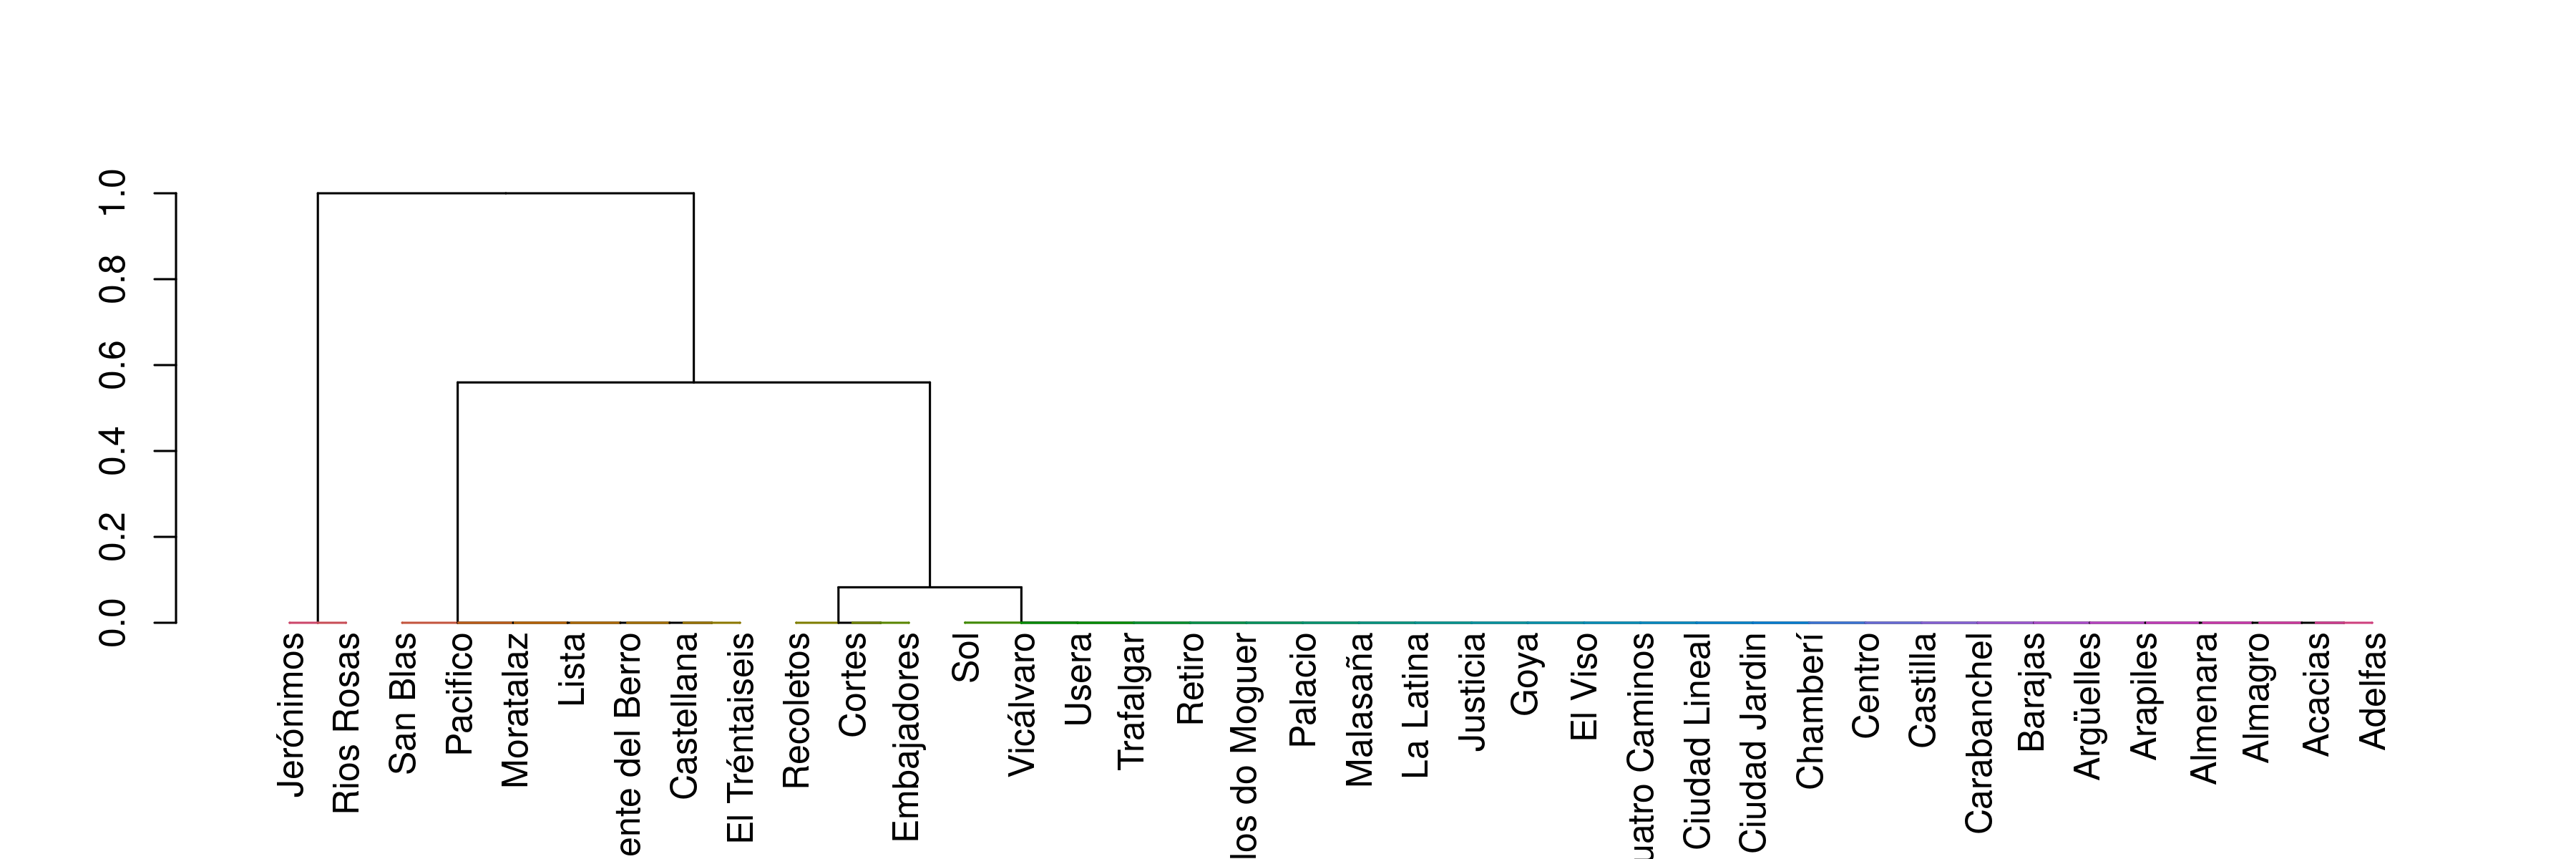

In [261]:
library(dendextend)
options(repr.plot.height=4,repr.plot.width=12)
d <- as.dist(1 - resm)
hc <- hclust(d,method="complete")
hcd <- as.dendrogram(hc)
plot(color_branches(hcd))

¿Que punto de corte sería el aconsejable?, ¿cuantos clusters aparecen?

[1] "Número de clusters:  4"


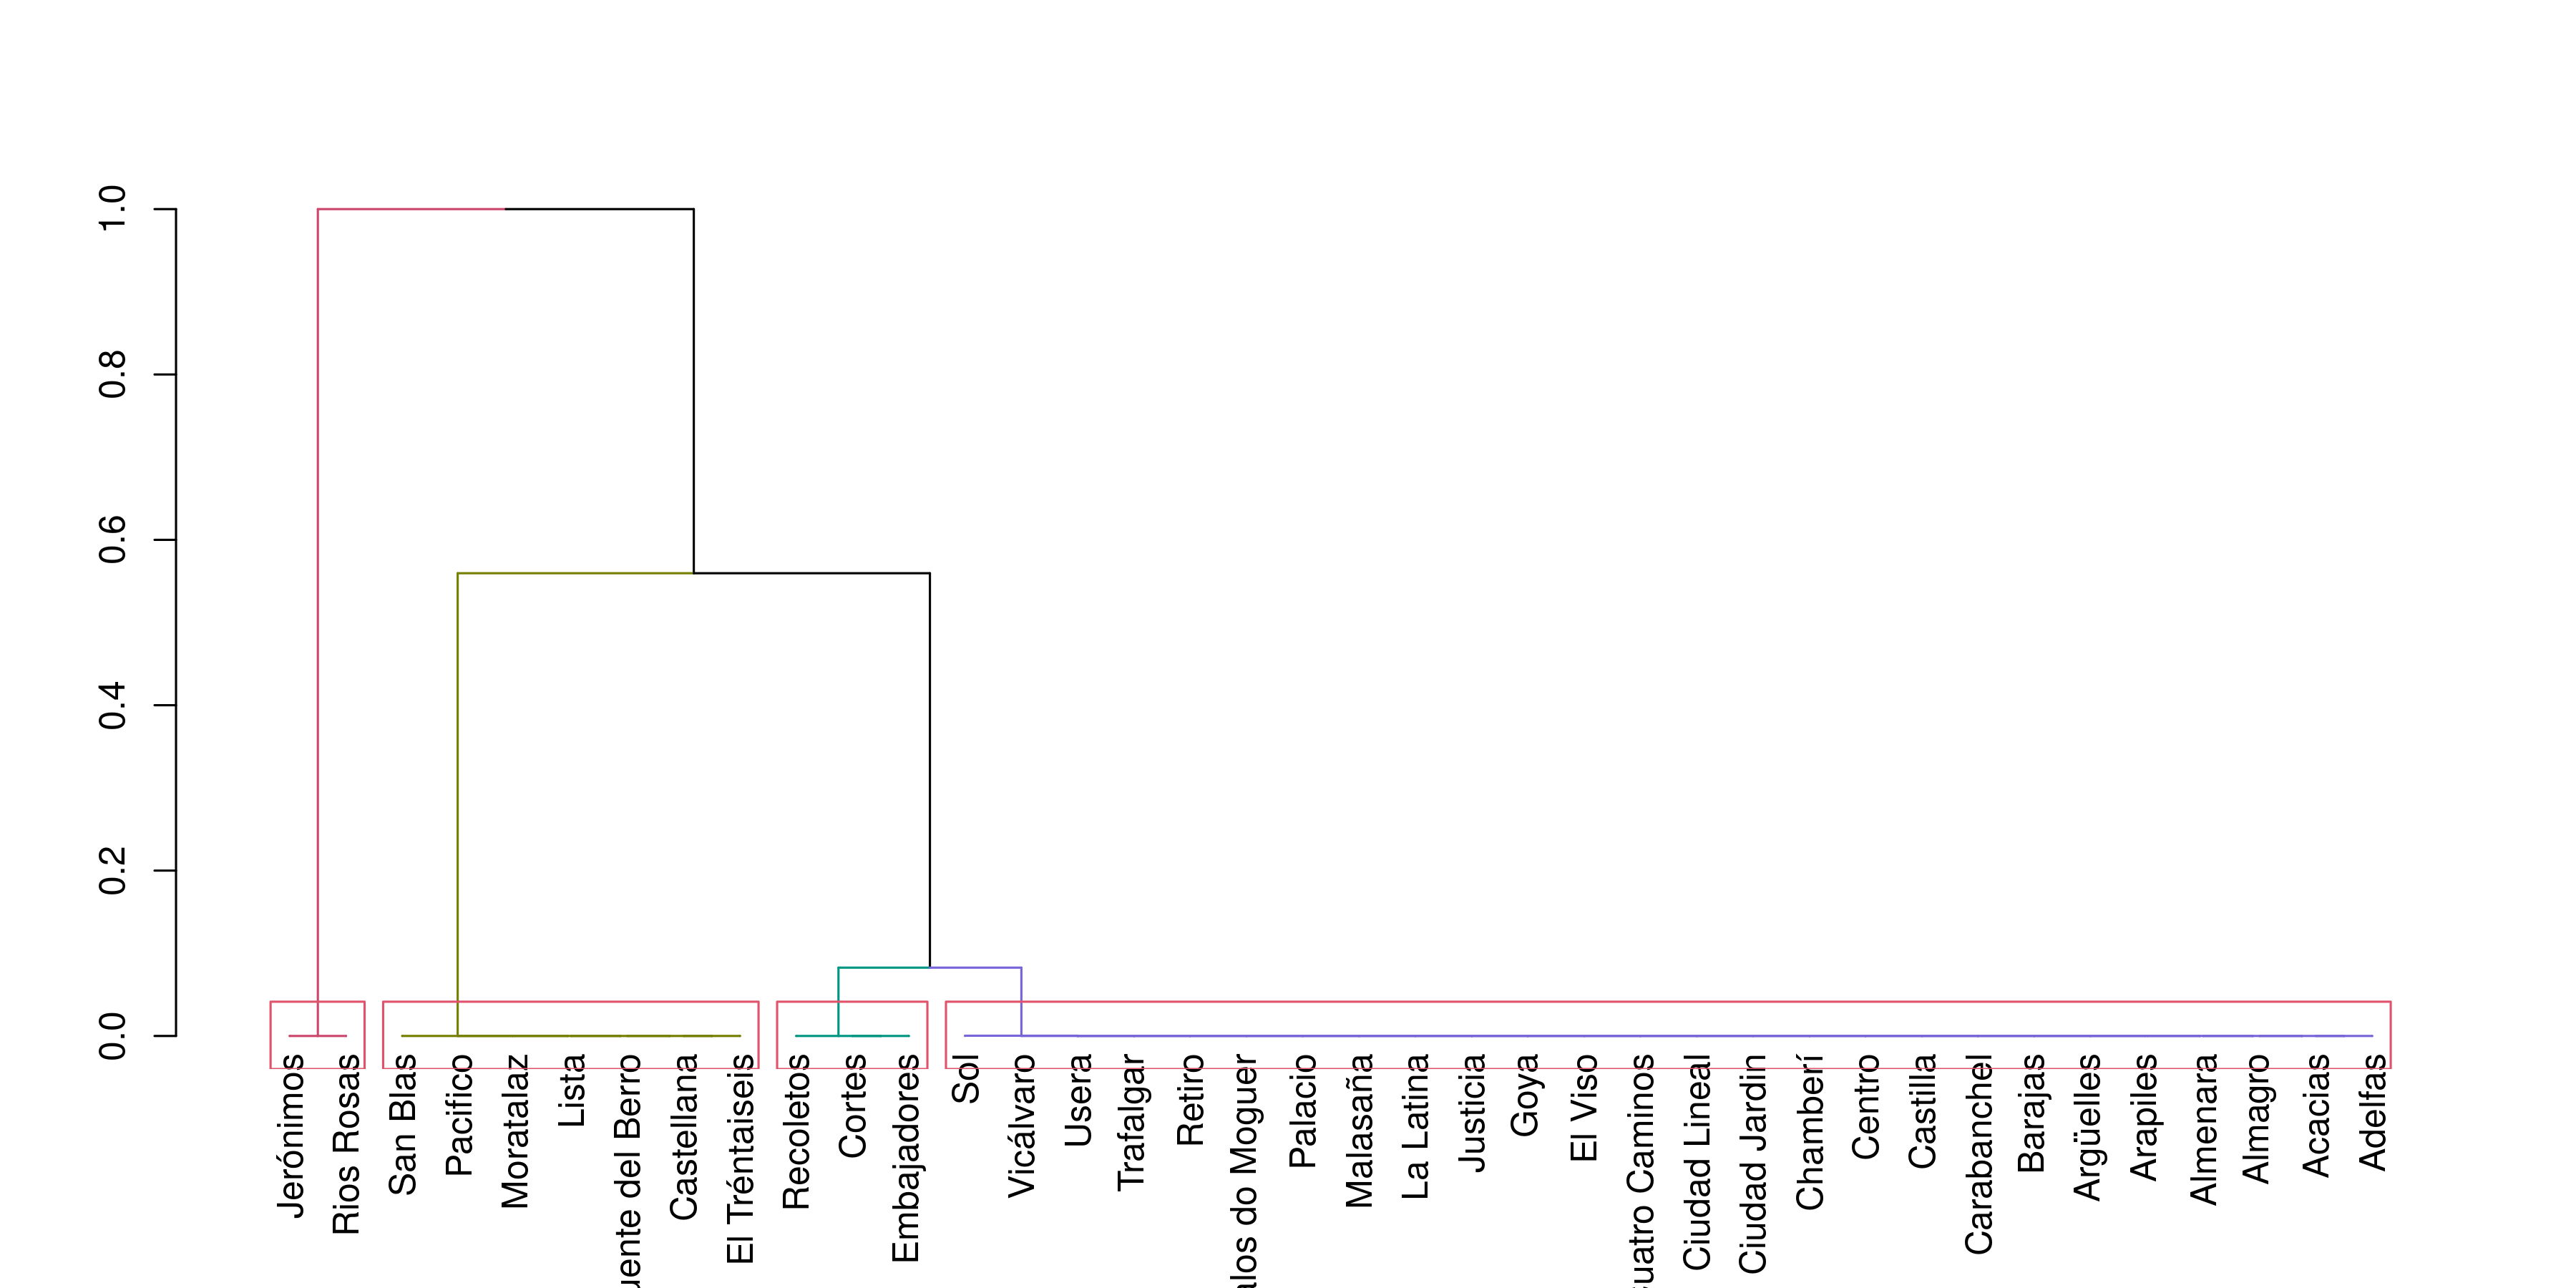

In [262]:
options(repr.plot.height=6,repr.plot.width=12)
plot(color_branches(hcd,h=0.01))
ncluster <- rect.hclust(hc, h=0.01)
print(paste("Número de clusters: ", length(ncluster)))

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [263]:
cluster <- as.factor(cutree(hc,h=0.01))
df_madrid$neighb_id <- cluster[df_madrid$Neighbourhood]
str(df_madrid)

'data.frame':	4901 obs. of  14 variables:
 $ Neighbourhood       : chr  "Palacio" "Malasaña" "Palacio" "La Latina" ...
 $ Accommodates        : int  2 4 8 2 2 3 2 6 4 2 ...
 $ Bathrooms           : num  1 1 3 1 NA 1 1 1 1 1 ...
 $ Bedrooms            : int  1 1 3 1 1 0 0 2 0 1 ...
 $ Beds                : int  1 2 4 1 NA 2 1 3 2 1 ...
 $ Price               : int  85 112 190 71 34 60 45 120 50 63 ...
 $ Square.Feet         : int  NA NA NA NA NA NA NA NA NA NA ...
 $ Guests.Included     : int  1 2 6 1 1 1 1 6 2 1 ...
 $ Extra.People        : int  0 5 40 0 6 0 0 30 8 0 ...
 $ Review.Scores.Rating: int  95 99 96 90 88 100 87 100 86 100 ...
 $ Latitude            : num  40.4 40.4 40.4 40.4 40.4 ...
 $ Longitude           : num  -3.71 -3.71 -3.72 -3.71 -3.7 ...
 $ Square.Meters       : num  NA NA NA NA NA NA NA NA NA NA ...
 $ neighb_id           : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 3 3 1 3 3 1 ...


Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados en función del resto de columnas del dataframe.

In [264]:
set.seed(1234)
idx <- sample(1:nrow(df_madrid),nrow(df_madrid)*0.7)
df_madrid_train <- df_madrid[idx,]
df_madrid_test <- df_madrid[-idx,]

In [265]:
# Probamos diferentes modelos
#Modelo_1
model_df_madrid1<-lm(Square.Meters~Accommodates+Bedrooms+Bathrooms+Beds+Price+neighb_id,data=df_madrid_train)
summary(model_df_madrid1)


Call:
lm(formula = Square.Meters ~ Accommodates + Bedrooms + Bathrooms + 
    Beds + Price + neighb_id, data = df_madrid_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.406 -11.010  -1.550   9.265  89.263 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   16.46391    5.14674   3.199  0.00178 ** 
Accommodates   0.16142    1.90033   0.085  0.93246    
Bedrooms      19.60603    3.24698   6.038 1.96e-08 ***
Bathrooms     14.66494    5.01553   2.924  0.00416 ** 
Beds          -1.59886    2.26525  -0.706  0.48173    
Price          0.05805    0.02728   2.128  0.03548 *  
neighb_id2     4.26250    8.25126   0.517  0.60644    
neighb_id3   -10.76798    4.96996  -2.167  0.03233 *  
neighb_id4    16.14218   17.14670   0.941  0.34847    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20.45 on 115 degrees of freedom
  (3306 observations deleted due to missingness)
Multiple R-squared:  0.7025,	Adjusted 

In [266]:
# Modelo_2. Sin Accommodates
model_df_madrid2<-lm(Square.Meters~Bedrooms+Bathrooms+Beds+Price+neighb_id,data=df_madrid_train)
summary(model_df_madrid2)


Call:
lm(formula = Square.Meters ~ Bedrooms + Bathrooms + Beds + Price + 
    neighb_id, data = df_madrid_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.358 -10.862  -1.431   9.290  89.160 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  16.59097    4.90344   3.384 0.000977 ***
Bedrooms     19.68567    3.09534   6.360 4.15e-09 ***
Bathrooms    14.81912    4.65550   3.183 0.001870 ** 
Beds         -1.48889    1.85084  -0.804 0.422788    
Price         0.05784    0.02705   2.138 0.034586 *  
neighb_id2    4.14241    8.09435   0.512 0.609788    
neighb_id3  -10.76198    4.94815  -2.175 0.031663 *  
neighb_id4   16.02690   17.01961   0.942 0.348317    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20.36 on 116 degrees of freedom
  (3306 observations deleted due to missingness)
Multiple R-squared:  0.7025,	Adjusted R-squared:  0.6845 
F-statistic: 39.13 on 7 and 116 DF,  p-value: < 2.2e-16


In [267]:
# Modelo_3. Sin neighb_id
model_df_madrid3<-lm(Square.Meters~Accommodates+Bedrooms+Bathrooms+Beds+Price,data=df_madrid_train)
summary(model_df_madrid3)


Call:
lm(formula = Square.Meters ~ Accommodates + Bedrooms + Bathrooms + 
    Beds + Price, data = df_madrid_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.687 -12.214  -0.659   9.164  88.064 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  12.28918    4.88727   2.515 0.013266 *  
Accommodates -0.20453    1.89317  -0.108 0.914152    
Bedrooms     20.64524    3.09317   6.674 8.51e-10 ***
Bathrooms    17.59073    4.53780   3.876 0.000175 ***
Beds         -1.95323    2.23484  -0.874 0.383898    
Price         0.05814    0.02742   2.120 0.036091 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20.71 on 118 degrees of freedom
  (3306 observations deleted due to missingness)
Multiple R-squared:  0.687,	Adjusted R-squared:  0.6737 
F-statistic: 51.79 on 5 and 118 DF,  p-value: < 2.2e-16


In [268]:
# Modelo_4. Sin Price 
model_df_madrid4<-lm(Square.Meters~Accommodates+Bedrooms+Bathrooms+Beds+neighb_id,data=df_madrid_train)
summary(model_df_madrid4)


Call:
lm(formula = Square.Meters ~ Accommodates + Bedrooms + Bathrooms + 
    Beds + neighb_id, data = df_madrid_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-49.970 -11.385  -1.132   8.304  91.320 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   15.6865     5.2135   3.009 0.003212 ** 
Accommodates  -0.2532     1.9305  -0.131 0.895865    
Bedrooms      19.7043     3.3097   5.953 2.81e-08 ***
Bathrooms     18.4940     4.8865   3.785 0.000244 ***
Beds          -0.3970     2.1964  -0.181 0.856880    
neighb_id2     8.8954     8.1813   1.087 0.279146    
neighb_id3   -10.3817     5.0683  -2.048 0.042762 *  
neighb_id4    13.9323    17.3772   0.802 0.424317    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20.87 on 117 degrees of freedom
  (3305 observations deleted due to missingness)
Multiple R-squared:  0.7022,	Adjusted R-squared:  0.6844 
F-statistic: 39.41 on 7 and 117 DF,  p-value: < 2.2e

In [269]:
# Nos quedamos con el modelo_2 que tiene el Adjusted R-squared más alto
df_madrid_test$predict_result<-predict(model_df_madrid2, df_madrid_test)

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

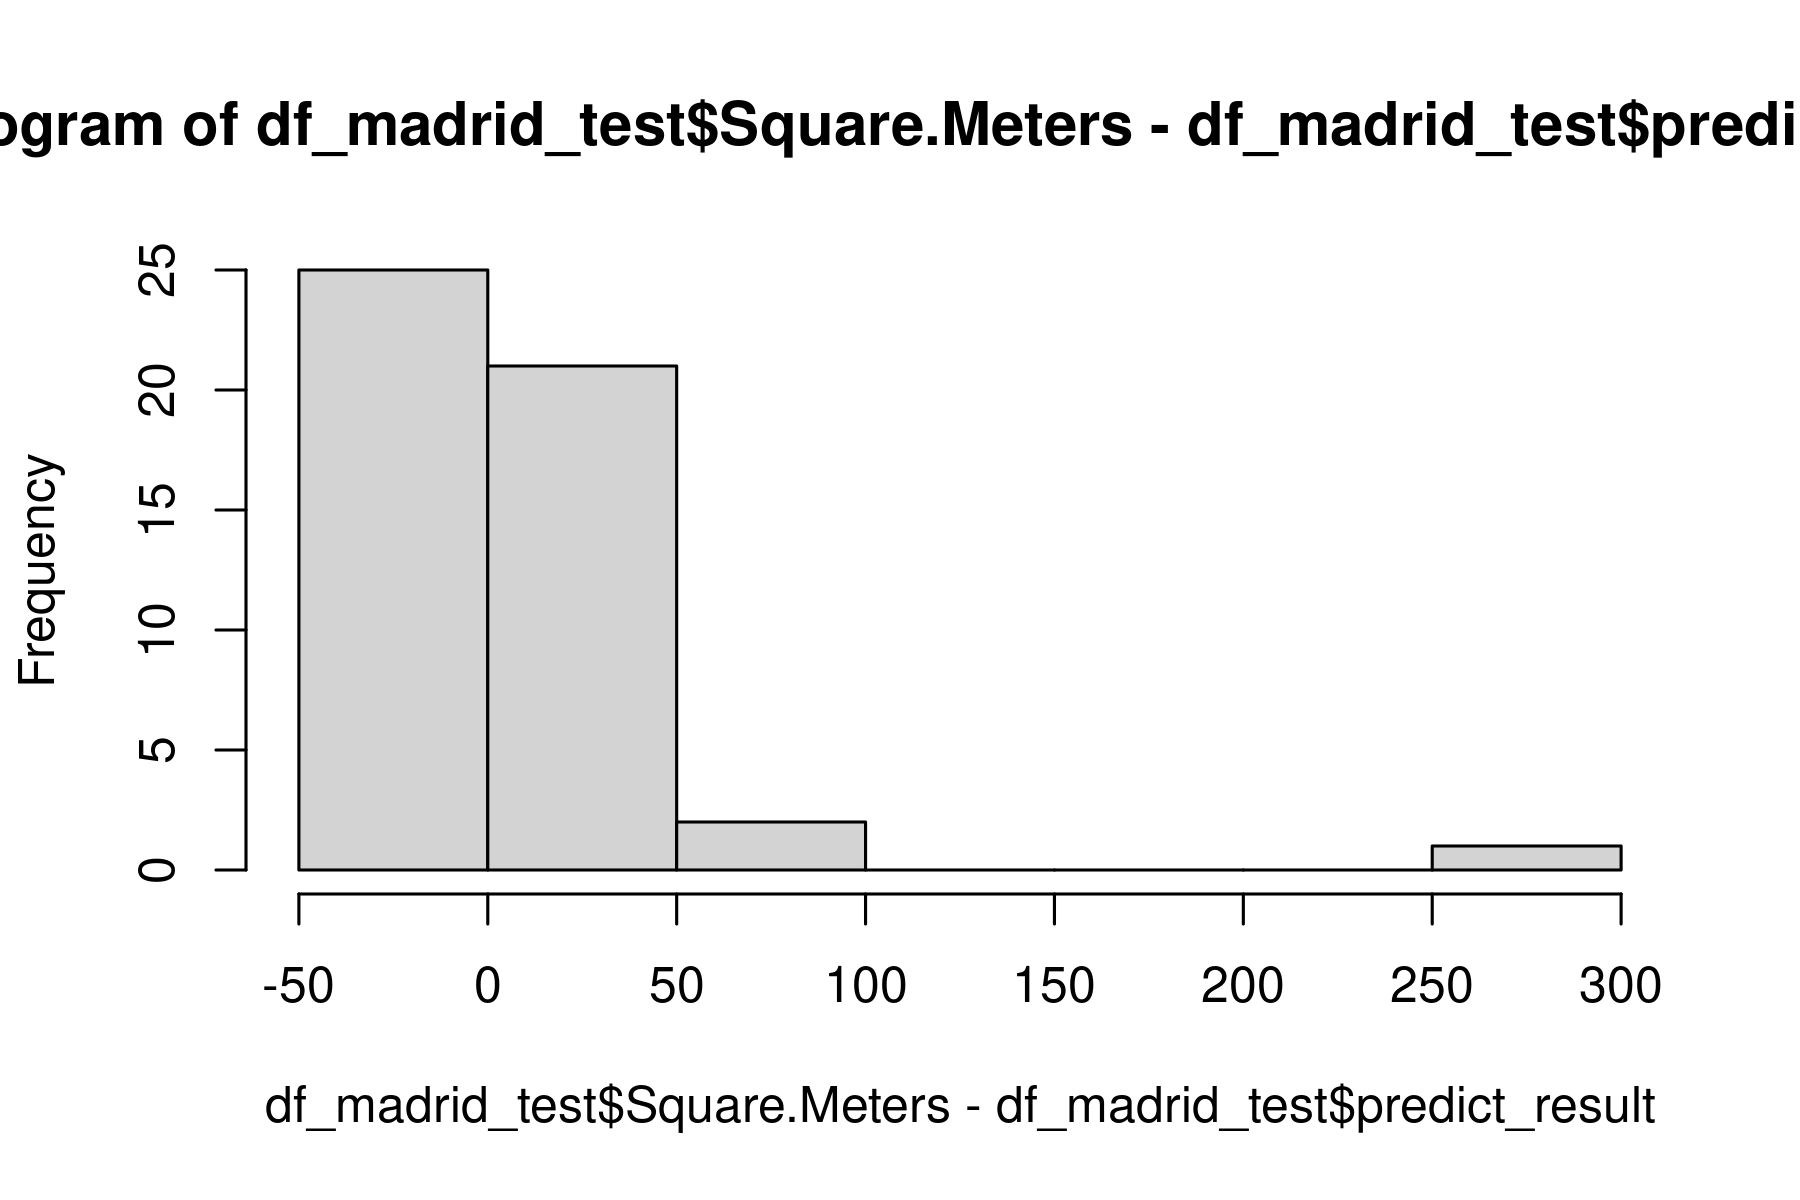

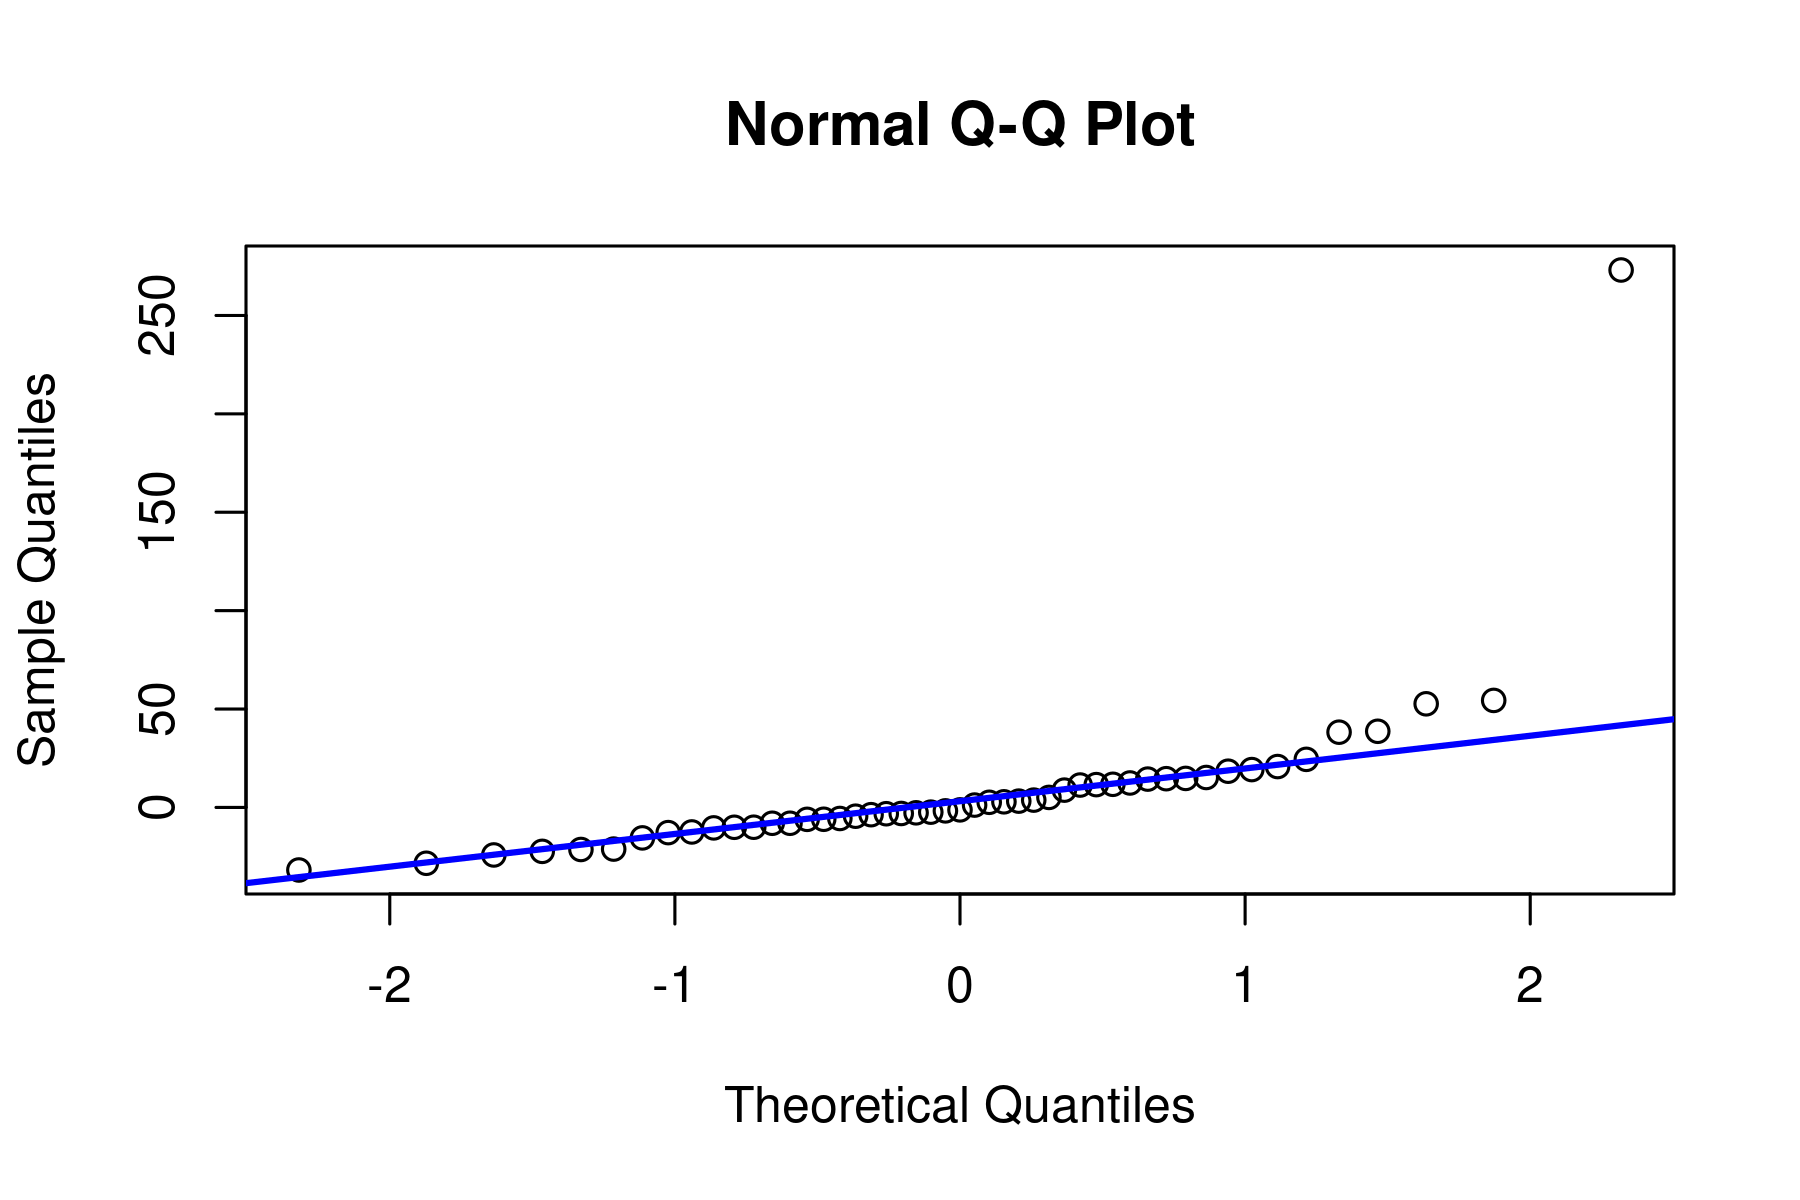

In [238]:
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)
hist(df_madrid_test$Square.Meters-df_madrid_test$predict_result,10)
qqnorm(df_madrid_test$Square.Meters-df_madrid_test$predict_result)
qqline(df_madrid_test$Square.Meters-df_madrid_test$predict_result, col = 'blue', lwd =2)

In [270]:
mean_sqerror <- sqrt(mean((df_madrid_test$Square.Meters-df_madrid_test$predict_result)^2,na.rm = TRUE))
paste("El error cuadrático medio es:",round(mean_sqerror,2))

[1] "El error cuadrático medio es: 43.23"

## <font color='red'>**Comentarios**</font>

Suele ser aconsejable mirar el error cuadrático y el R^2 tanto en test como en training para comparar.

Por lo que veo del error cuadrico medio que enseñas, parece que es bastante más alto en training que en test. Esto indicaría overfitting e implicaría que tu modelo es demasiado completo, tal vez deberías eliminar alguna variable.

Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates), con 1 baño, con un precio de 80€/noche y 3 habitaciones en el barrio de Sol, con 3 camas y un review de 80.
¿Cuantos metros cuadrados tendría? Si tu modelo necesita algúna variable adicional puedes inventartela dentro del rango de valores del dataset.
¿Como varía sus metros cuadrados con cada habitación adicional?

In [271]:
df_apartment <- data.frame(
    "Accommodates" = 6,
    "Bathrooms" = 1,
    "Price" = 80,
    "Bedrooms" = 3,
    "Neighbourhood" = "Sol",    
    "Beds" = 3,
    "Review.Scores.Rating" = 80,
    "neighb_id" = as.factor(4)
)

In [272]:
pr_meters_1 <- predict(model_df_madrid2, df_apartment, na.action = na.pass)
round(pr_meters_1,2)

1 
106.65

In [273]:
#por cada habitacion sube
round(model_df_madrid2$coefficients["Bedrooms"],2)

Bedrooms 
   19.69

In [274]:
df_apartment <- data.frame(
    "Accommodates" = 6,
    "Bathrooms" = 1,
    "Price" = 80,
    "Bedrooms" = 4,
    "Neighbourhood" = "Sol",    
    "Beds" = 3,
    "Review.Scores.Rating" = 80,
    "neighb_id" = as.factor(4)
)
pr_meters_2 <- predict(model_df_madrid2, df_apartment, na.action = na.pass)
round(pr_meters_2)

1 
126

In [276]:
pr_meters_2 - pr_meters_1

1 
19.68567

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

In [277]:
index <- which(is.na(df_madrid$Square.Meters))
df_madrid$Square.Meters[index] <- predict(model_df_madrid4, df_madrid)[index]

Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

In [279]:
df_sub_madrid <- subset(df_madrid, 
                 select = c('Accommodates','Bathrooms','Bedrooms','Beds','Price','Guests.Included',
                            'Extra.People','Review.Scores.Rating','Latitude', 'Longitude', 'Square.Meters'))
df_sub_madrid <- na.omit(df_sub_madrid)


df_apartment <- df_sub_madrid[50,c('Accommodates','Bathrooms','Bedrooms','Beds','Price','Guests.Included',
                            'Extra.People','Review.Scores.Rating','Latitude', 'Longitude', 'Square.Meters')]
df_apartment

,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1915,3,1,1,2,68,2,15,95,40.41212,-3.696957,41.94945


In [280]:
most_similar_apts <- function(df_complete, new_item, num_items=5){
    pr_apt <- prcomp(df_complete,center = TRUE, scale. = TRUE)
    t_apt <- predict(pr_apt, newdata = new_item)
    dist<-rowSums((t_apt[rep(1, times = nrow(pr_apt$x)), ]-pr_apt$x)^2)
    df_complete[order(dist)[1:num_items],]
}



## <font color='red'>**Comentarios**</font>

Realmente aquí yo habría mirado el peso de los autovalores, y hubiera visto cuales son los más importantes.

Te podrías quedar con los 2 o 3 primeros que son los que tienen más información (mayor varianza) y hacer la comparación sobre esos elementos.

Comparar todos no sería tan efectivo porque con la distancia euclidea le estas dando el mismo poder discriminatorio a todas las variables. Aunque por otra parte los autovectores más altos tampoco tendrían mucha varianza así que no es un problema muy importante.



In [248]:
most_similar_apts(df_sub_madrid, df_apartment)

,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1915,3,1,1,2,68,2,15,95,40.41212,-3.696957,41.94945
330833,3,1,1,2,65,2,15,96,40.41359,-3.697519,41.94945
162212,3,1,1,2,68,2,15,96,40.41115,-3.694259,41.94945
48131,3,1,1,2,71,2,15,96,40.40872,-3.699191,41.94945
423164,3,1,1,2,55,2,14,93,40.41081,-3.694998,41.94945


Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?